11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Step 0, Train Acc: 0.0020, Test Acc: 0.2670, Loss: 0.0115
Step 200, Train Acc: 0.7278, Test Acc: 0.8200, Loss: 0.9242
Step 400, Train Acc: 0.8816, Test Acc: 0.8610, Loss: 0.4244
Step 600, Train Acc: 0.9037, Test Acc: 0.8870, Loss: 0.3401
Step 800, Train Acc: 0.9171, Test Acc: 0.8960, Loss: 0.2900
Step 1000, Train Acc: 0.9319, Test Acc: 0.9550, Loss: 0.2467
Step 1200, Train Acc: 0.9439, Test Acc: 0.9520, Loss: 0.2061
Step 1400, Train Acc: 0.9505, Test Acc: 0.9760, Loss: 0.1814
Step 1600, Train Acc: 0.9536, Test Acc: 0.9810, Loss: 0.1630
Step 1800, Train Acc: 0.9593, Test Acc: 0.9570, Loss: 0.1468
Step 2000, Train Acc: 0.9648, Test Acc: 0.9580, Loss: 0.1287
Step 2200, Train Acc: 0.9668, Test Acc: 0.9580, Loss: 0.1185
Step 2400, Train Acc: 0.9698, Test Acc: 0.9610, Loss: 0.1115
Step 2600, Train Acc: 0.9742, Test Acc: 0.9590, Loss: 0.0955
Step 2800, Train Acc: 0.9753, Test Acc: 0.9670, Loss: 0.0933
Step 3000, Train Acc: 0.9754, Test Acc: 0

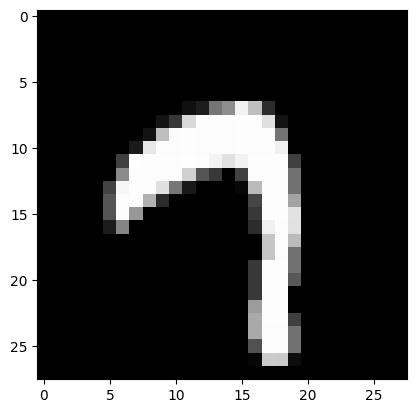

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from types import SimpleNamespace

# Load MNIST dataset
def load_mnist():
    def preprocess(data, labels, num_classes):
        data = data.astype(np.float32) / 255.0
        data = np.reshape(data, [data.shape[0], -1])
        num_labels = labels.shape[0]
        index_offset = np.arange(num_labels) * num_classes
        labels_one_hot = np.zeros((num_labels, num_classes))
        labels_one_hot.flat[index_offset + labels.ravel()] = 1
        return data, labels_one_hot

    train, test = tf.keras.datasets.mnist.load_data()
    train = preprocess(train[0], train[1], 10)
    test = preprocess(test[0], test[1], 10)
    return SimpleNamespace(train=Dataset(train), test=Dataset(test))

# Dataset class
class Dataset():
    def __init__(self, data):
        self.data = data
        self.index = 0
        self.epochs = 0

    def shuffle(self):
        perm = np.arange(self.data[0].shape[0])
        np.random.shuffle(perm)
        self.data = tuple(datai[perm] for datai in self.data)

    def next_batch(self, batch_size):
        start = self.index
        end = self.index + batch_size
        if end > self.data[0].shape[0]:
            self.epochs += 1
            self.shuffle()
            self.index, start = 0, 0
            end = batch_size
        self.index = end
        return tuple(datai[start:end, ...] for datai in self.data)

# Define MLP with two hidden layers
class DenseLayer:
    def __init__(self, n_inputs, n_units, afunc=tf.nn.relu, w_stddev=0.01):
        self.w = tf.Variable(
            tf.random.truncated_normal([n_inputs, n_units], stddev=w_stddev), name='w')
        self.b = tf.Variable(tf.zeros([n_units]), name='b')
        self.afunc = afunc

    def trainable_variables(self):
        return [self.w, self.b]

    def __call__(self, x):
        y = tf.matmul(x, self.w) + self.b
        return self.afunc(y) if self.afunc else y

class MLPModel:
    def __init__(self, activation=tf.nn.relu):
        self.layers = [
            DenseLayer(28 * 28, 100, afunc=activation),
            DenseLayer(100, 100, afunc=activation),
            DenseLayer(100, 10, afunc=None)  # Output layer
        ]

    def trainable_variables(self):
        return [var for layer in self.layers for var in layer.trainable_variables()]

    def __call__(self, x, logits=False):
        output = x
        for layer in self.layers:
            output = layer(output)
        return output if logits else tf.nn.softmax(output)

# Loss function
def loss_fn(logits, labels):
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))

# Training function
def train_step(model, optimizer, batch_x, batch_y):
    with tf.GradientTape() as tape:
        logits = model(batch_x, logits=True)
        loss = loss_fn(logits, batch_y)
    gradients = tape.gradient(loss, model.trainable_variables())
    optimizer.apply_gradients(zip(gradients, model.trainable_variables()))
    return loss.numpy(), model(batch_x).numpy()

# Training parameters
batch_size = 100
num_steps = 10000
summary_freq = 200

# Train and evaluate
mnist = load_mnist()
optimizer = tf.optimizers.Adam(1e-3)
activation_fn = tf.nn.relu  # Change to tf.nn.sigmoid to compare
model = MLPModel(activation=activation_fn)

mean_loss = 0
train_accuracy = 0

for step in range(num_steps):
    batch_X, batch_y = mnist.train.next_batch(batch_size)
    loss, train_pred = train_step(model, optimizer, batch_X, batch_y)
    train_accuracy += np.mean(np.argmax(train_pred, axis=1) == np.argmax(batch_y, axis=1))
    mean_loss += loss

    if step % summary_freq == 0:
        train_accuracy /= summary_freq
        test_accuracy = np.mean([
            np.argmax(model(batch_X_test).numpy(), axis=1) == np.argmax(batch_y_test, axis=1)
            for batch_X_test, batch_y_test in [mnist.test.next_batch(batch_size) for _ in range(10)]
        ])
        print(f"Step {step}, Train Acc: {train_accuracy:.4f}, Test Acc: {test_accuracy:.4f}, Loss: {mean_loss / summary_freq:.4f}")
        mean_loss = 0
        train_accuracy = 0

# Evaluate a single test sample
test_sample_x, test_sample_y = mnist.test.next_batch(1)
pred = model(test_sample_x).numpy()
print('Actual:', np.argmax(test_sample_y))
print('Predicted:', np.argmax(pred))

plt.imshow(np.reshape(test_sample_x, [28, 28]), cmap='gray')
plt.show()
